<a href="https://colab.research.google.com/github/17092003vamsi/HUNTER/blob/main/SVM_3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Test Accuracy: 0.9572


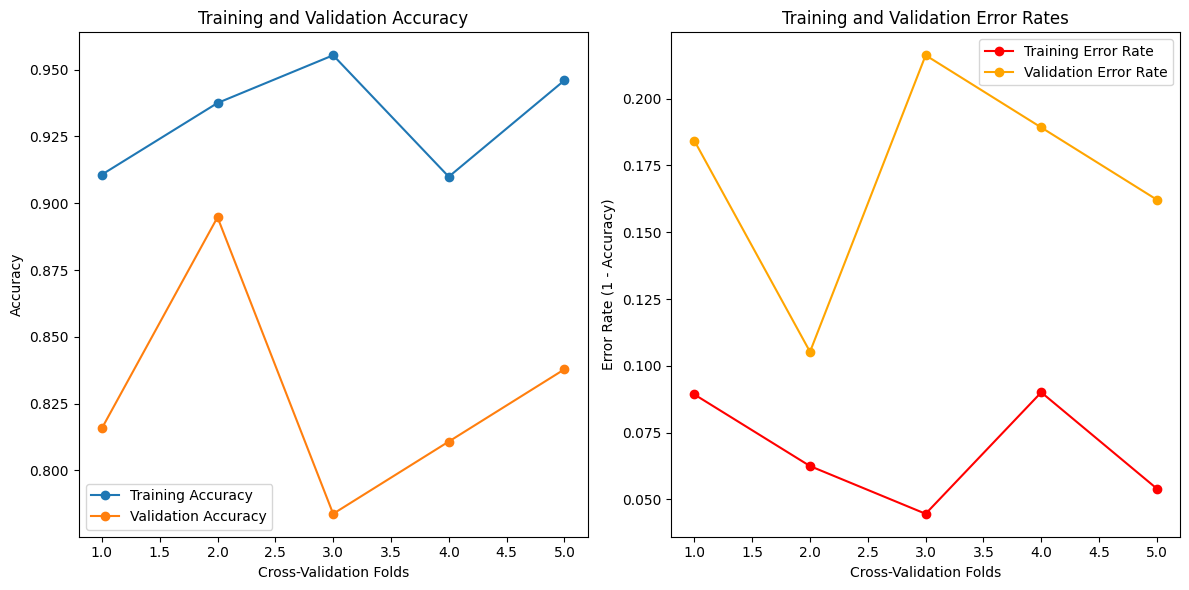

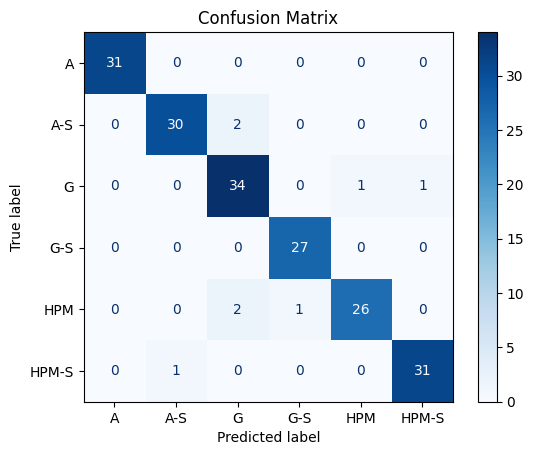

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        31
         A-S       0.97      0.94      0.95        32
           G       0.89      0.94      0.92        36
         G-S       0.96      1.00      0.98        27
         HPM       0.96      0.90      0.93        29
       HPM-S       0.97      0.97      0.97        32

    accuracy                           0.96       187
   macro avg       0.96      0.96      0.96       187
weighted avg       0.96      0.96      0.96       187



  0%|          | 0/100 [00:00<?, ?it/s]

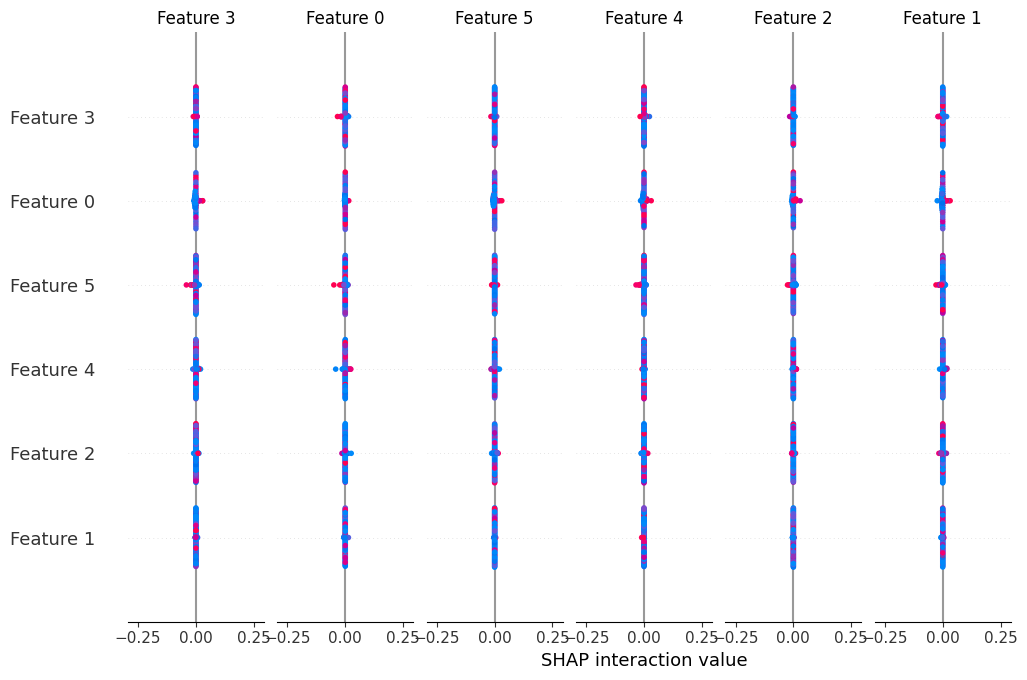

  0%|          | 0/100 [00:00<?, ?it/s]

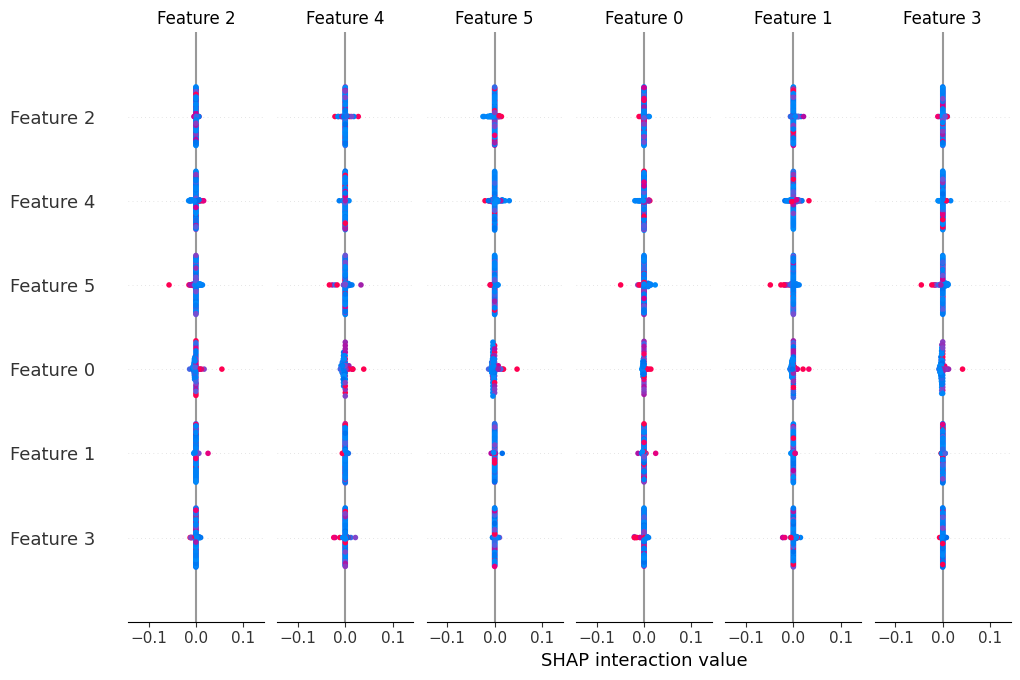

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import shap
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/project 2 sap.csv')

# Encode categorical features
type_encoder = LabelEncoder()
data['Type'] = type_encoder.fit_transform(data['Type'])

label_encoder = LabelEncoder()
data['Lable'] = label_encoder.fit_transform(data['Lable'])

# Separate features and target
X = data.drop(columns=['Lable'])
y = data['Lable']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Further split training data to create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Train the SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_test = svm_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

# Cross-validation scores
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_scores = cross_val_score(svm_model, X_train, y_train, cv=skf)
val_scores = cross_val_score(svm_model, X_val, y_val, cv=skf)
train_error_rates = 1 - train_scores
val_error_rates = 1 - val_scores

# Plot training and validation accuracy and error rates
folds = np.arange(1, len(train_scores) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(folds, train_scores, label='Training Accuracy', marker='o')
plt.plot(folds, val_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Cross-Validation Folds')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(folds, train_error_rates, label='Training Error Rate', marker='o', color='red')
plt.plot(folds, val_error_rates, label='Validation Error Rate', marker='o', color='orange')
plt.xlabel('Cross-Validation Folds')
plt.ylabel('Error Rate (1 - Accuracy)')
plt.legend()
plt.title('Training and Validation Error Rates')

plt.tight_layout()
plt.show()

# Confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

# SHAP analysis
# Limit SHAP calculations to a sample for performance
X_val_sample = X_val[:100]  # Sample 100 instances from validation set
X_test_sample = X_test[:100]  # Sample 100 instances from test set

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(svm_model.predict_proba, shap.kmeans(X_train, 10))

# SHAP values for the validation set
shap_values_val = explainer.shap_values(X_val_sample)
shap.summary_plot(shap_values_val, X_val_sample, plot_type="bar")

# SHAP values for the test set
shap_values_test = explainer.shap_values(X_test_sample)
shap.summary_plot(shap_values_test, X_test_sample, plot_type="bar")
